## Load Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
# libgomp issue, must import n2 before torch
from n2 import HnswIndex

In [4]:
import sys

sys.path.insert(0, '..')

In [5]:
import os
home_dir = os.getenv('HOME')

https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution

https://www.informatik.uni-leipzig.de/~saeedi/musicBrainz_readme.txt

```
5 sources
---------- 
TID: a unique record's id (in the complete dataset).
CID: cluster id (records having the same CID are duplicate)
CTID: a unique id within a cluster (if two records belong to the same cluster they will have the same CID but different CTIDs). These ids (CTID) start with 1 and grow until cluster size.
SourceID: identifies to which source a record belongs (there are five sources). The sources are deduplicated.
Id: the original id from the source. Each source has its own Id-Format. Uniqueness is not guaranteed!! (can be ignored).
number: track or song number in the album.
length: the length of the track.
artist: the interpreter (artist or band) of the track.
year: date of publication.
language: language of the track.
```

In [6]:
import glob
import csv
from tqdm.auto import tqdm

current_row_id = 0
row_dict = {}
rows_total = 19375
clusters_total = 10000
cluster_attr = 'CID'

with tqdm(total=rows_total) as pbar:
    with open(f'{home_dir}/Downloads/musicbrainz-20-A01.csv.dapo') as f:
        for row in csv.DictReader(f):
            row['id'] = current_row_id
            row[cluster_attr] = int(row[cluster_attr])  # convert cluster_attr to int
            row_dict[current_row_id] = row
            current_row_id += 1
            pbar.update(1)

In [7]:
row_dict[1]

{'TID': '2',
 'CID': 2512,
 'CTID': '5',
 'SourceID': '4',
 'id': 1,
 'number': '7',
 'title': '007',
 'length': '1m 58sec',
 'artist': '[unknown]',
 'album': 'Cantigas de roda (unknown)',
 'year': 'null',
 'language': 'Por.'}

## Preprocess

In [8]:
attr_list = ['title', 'artist', 'album']

In [9]:
import unidecode
from entity_embed import default_tokenizer

def clean_str(s):
    s = unidecode.unidecode(s).lower().strip()
    return ' '.join(s_part[:30] for s_part in default_tokenizer(s))[:100]

for row in tqdm(row_dict.values()):
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

## Init Data Module

In [10]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [11]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

In [12]:
attr_info_dict = {
    'title': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'artist': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'album': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    }
}

In [13]:
from entity_embed import build_row_numericalizer

row_numericalizer = build_row_numericalizer(attr_info_dict, row_dict=row_dict)
row_numericalizer.attr_info_dict

10:40:05 INFO:For attr='title', computing actual alphabet and max_str_len
10:40:05 INFO:For attr='title', using actual_max_str_len=30
10:40:05 INFO:For attr='artist', computing actual alphabet and max_str_len
10:40:05 INFO:For attr='artist', using actual_max_str_len=30
10:40:05 INFO:For attr='album', computing actual alphabet and max_str_len
10:40:05 INFO:For attr='album', using actual_max_str_len=30


{'title': NumericalizeInfo(field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer=<function default_tokenizer at 0x7fe05eaccaf0>, alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=30, vocab=None),
 'artist': NumericalizeInfo(field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer=<function default_tokenizer at 0x7fe05eaccaf0>, alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}',

In [14]:
from entity_embed import DeduplicationDataModule

train_cluster_len = 1500
valid_cluster_len = 2500
datamodule = DeduplicationDataModule(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    batch_size=50,
    row_batch_size=16,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    only_plural_clusters=True,
    random_seed=random_seed
)

## Training

In [15]:
from entity_embed import EntityEmbed

ann_k = 10
model = EntityEmbed(
    datamodule,
    ann_k=ann_k,
    use_mask=False
)

In [16]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 50
early_stop_callback = EarlyStopping(
   monitor='valid_recall_at_0.5',
   min_delta=0.00,
   patience=10,
   verbose=True,
   mode='max'
)
tb_log_dir = 'tb_logs'
tb_name = 'music'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_log_dir, name=tb_name)
)

10:40:05 INFO:GPU available: True, used: True
10:40:05 INFO:TPU available: None, using: 0 TPU cores
10:40:05 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [17]:
trainer.fit(model, datamodule)

10:40:05 INFO:Train pair count: 4883
10:40:05 INFO:Valid pair count: 8092
10:40:05 INFO:Test pair count: 3275
10:40:07 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 3.4 M 
1 | losser      | SupConLoss | 0     
-------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params


1

In [18]:
model.blocker_net.get_signature_weights()

{'title': 0.360125333070755,
 'artist': 0.3023812174797058,
 'album': 0.3374934494495392}

## Testing

In [19]:
trainer.test(ckpt_path='best')

10:44:59 INFO:Train pair count: 4883
10:44:59 INFO:Valid pair count: 8092
10:44:59 INFO:Test pair count: 3275



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_f1_at_0.3': 0.31738429206783636,
 'test_f1_at_0.5': 0.825758545640763,
 'test_f1_at_0.7': 0.9662473151273397,
 'test_f1_at_0.9': 0.8232758620689655,
 'test_pair_entity_ratio_at_0.3': 5.950831024930748,
 'test_pair_entity_ratio_at_0.5': 1.5706371191135735,
 'test_pair_entity_ratio_at_0.7': 1.1229224376731302,
 'test_pair_entity_ratio_at_0.9': 0.7939750692520776,
 'test_precision_at_0.3': 0.18893285232165716,
 'test_precision_at_0.5': 0.7109788359788359,
 'test_precision_at_0.7': 0.9710144927536232,
 'test_precision_at_0.9': 0.9995638901003053,
 'test_recall_at_0.3': 0.9914503816793893,
 'test_recall_at_0.5': 0.9847328244274809,
 'test_recall_at_0.7': 0.9615267175572519,
 'test_recall_at_0.9': 0.6998473282442748}
--------------------------------------------------------------------------------


[{'test_precision_at_0.3': 0.18893285232165716,
  'test_recall_at_0.3': 0.9914503816793893,
  'test_f1_at_0.3': 0.31738429206783636,
  'test_pair_entity_ratio_at_0.3': 5.950831024930748,
  'test_precision_at_0.5': 0.7109788359788359,
  'test_recall_at_0.5': 0.9847328244274809,
  'test_f1_at_0.5': 0.825758545640763,
  'test_pair_entity_ratio_at_0.5': 1.5706371191135735,
  'test_precision_at_0.7': 0.9710144927536232,
  'test_recall_at_0.7': 0.9615267175572519,
  'test_f1_at_0.7': 0.9662473151273397,
  'test_pair_entity_ratio_at_0.7': 1.1229224376731302,
  'test_precision_at_0.9': 0.9995638901003053,
  'test_recall_at_0.9': 0.6998473282442748,
  'test_f1_at_0.9': 0.8232758620689655,
  'test_pair_entity_ratio_at_0.9': 0.7939750692520776}]

In [20]:
import gc
del trainer
gc.collect()

15

## Testing manually 

In [21]:
# Only call this if test above wasn't run
# datamodule.setup(stage='test')

In [22]:
test_row_dict = datamodule.test_row_dict
test_vector_dict = model.predict(
    row_dict=test_row_dict,
    batch_size=16
)

In [23]:
embedding_size = model.blocker_net.embedding_size
test_true_pair_set = datamodule.test_true_pair_set

In [24]:
import gc
del model
del datamodule
gc.collect()

4696

In [25]:
assert len(test_vector_dict) == len(test_row_dict)

In [26]:
%%time

from entity_embed import ANNEntityIndex

ann_index = ANNEntityIndex(embedding_size=embedding_size)
ann_index.insert_vector_dict(test_vector_dict)
ann_index.build()

CPU times: user 843 ms, sys: 13.7 ms, total: 857 ms
Wall time: 139 ms


In [27]:
%%time

sim_threshold = 0.5
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold
)

CPU times: user 998 ms, sys: 0 ns, total: 998 ms
Wall time: 106 ms


In [28]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

1.5706371191135735

In [29]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.7109788359788359, 0.9847328244274809)

In [30]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

1311

In [31]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

50

In [32]:
cos_similarity = lambda a, b: np.dot(a, b)

In [33]:
for (id_left, id_right) in false_negatives[:10]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.13644648,
 {'TID': '15081',
  'CID': 5099,
  'CTID': '5',
  'SourceID': '1',
  'id': 15080,
  'number': '011',
  'title': "i ' ve never been to me ( hits of the 80s : the ultimate collection )",
  'length': '04:00',
  'artist': 'chrlene',
  'album': 'hits of the 80s : the ultimate collection',
  'year': '2006',
  'language': ''},
 {'TID': '17910',
  'CID': 5099,
  'CTID': '4',
  'SourceID': '5',
  'id': 17909,
  'number': '5612990',
  'title': '11',
  'length': "I've Never Been to Me",
  'artist': '240440',
  'album': 'charlene',
  'year': 'Hits of the 80s: The Ultimate Collection',
  'language': '2006'})

(0.45221782,
 {'TID': '1819',
  'CID': 966,
  'CTID': '1',
  'SourceID': '5',
  'id': 1818,
  'number': '9',
  'title': 'barcarolleinfsharp , op . 60',
  'length': '451586',
  'artist': 'fryderykchopin',
  'album': 'kefultimateresolutiondemonstra , editionno . 2',
  'year': '2010',
  'language': 'English'},
 {'TID': '9052',
  'CID': 966,
  'CTID': '2',
  'SourceID': '1',
  'id': 9051,
  'number': '009',
  'title': 'barcarolle in f sharp , op . 60 ( kef ultimate resolution demonstration disc , edition no . 2 )',
  'length': '07:31',
  'artist': 'fryderyk chopin',
  'album': 'kef ultimate resolution demonstration disc , edition no . 2',
  'year': '2010',
  'language': ''})

(0.1933518,
 {'TID': '2905',
  'CID': 2371,
  'CTID': '2',
  'SourceID': '3',
  'id': 2904,
  'number': '6',
  'title': 'unnown',
  'length': '4.4',
  'artist': 'sorg uten tarer',
  'album': '',
  'year': "'07",
  'language': 'English'},
 {'TID': '9261',
  'CID': 2371,
  'CTID': '3',
  'SourceID': '4',
  'id': 9260,
  'number': '6',
  'title': '006 - moonkissed eyes',
  'length': '4m 24sec',
  'artist': 'sorg uten tarer',
  'album': 'moonsilver ( 2007 )',
  'year': 'null',
  'language': 'Eng.'})

(0.42092627,
 {'TID': '2208',
  'CID': 1154,
  'CTID': '1',
  'SourceID': '1',
  'id': 2207,
  'number': '020',
  'title': 'space jerk ( promos 5 : kidz stuff )',
  'length': '00:29',
  'artist': 'kevin jarvis',
  'album': 'promos 5 : kidz stuff',
  'year': '',
  'language': ''},
 {'TID': '14346',
  'CID': 1154,
  'CTID': '3',
  'SourceID': '3',
  'id': 14345,
  'number': '20',
  'title': 'nulll',
  'length': '0.483',
  'artist': 'evin jarvis',
  'album': '',
  'year': '',
  'language': 'English'})

(0.37308067,
 {'TID': '9364',
  'CID': 901,
  'CTID': '2',
  'SourceID': '2',
  'id': 9363,
  'number': 'A5',
  'title': 'du bian man li nai - marinanoxia',
  'length': 'null',
  'artist': '',
  'album': "oniyanzi sailing meng gong chang ' 87 live",
  'year': '87',
  'language': 'Japanese'},
 {'TID': '16923',
  'CID': 901,
  'CTID': '4',
  'SourceID': '4',
  'id': 16922,
  'number': 'A5',
  'title': '0a5 -',
  'length': 'unknown',
  'artist': '',
  'album': 'sailin 87 live ( 1987 )',
  'year': 'null',
  'language': 'Jap.'})

(0.25253367,
 {'TID': '895',
  'CID': 2198,
  'CTID': '2',
  'SourceID': '3',
  'id': 894,
  'number': '4',
  'title': 'the cn tower belongs to the dead ( many ives version ) - many lives - 49 mp',
  'length': '5.467',
  'artist': 'final fantasy',
  'album': '',
  'year': "'06",
  'language': 'English'},
 {'TID': '4240',
  'CID': 2198,
  'CTID': '1',
  'SourceID': '2',
  'id': 4239,
  'number': '4',
  'title': 'n . a .',
  'length': '328',
  'artist': '',
  'album': 'many lives - 49 mp',
  'year': '06',
  'language': 'English'})

(0.65071255,
 {'TID': '1363',
  'CID': 715,
  'CTID': '1',
  'SourceID': '3',
  'id': 1362,
  'number': '8',
  'title': 'cantata , bwv 2 " ach gott , vom himmel sieh darein ": ii . recitativo " sie lehren eitel falsche li',
  'length': '1.033',
  'artist': 'johann sebastian bach',
  'album': '',
  'year': "'99",
  'language': 'English'},
 {'TID': '5004',
  'CID': 715,
  'CTID': '3',
  'SourceID': '5',
  'id': 5003,
  'number': '8',
  'title': '2',
  'length': '6 2000',
  'artist': 'johann sebastian bach',
  'album': 'bach 2000 : the complete bach edition , volume 1 : sacred cantatas : bwv 1 - 14 , 16 - 47',
  'year': '1999',
  'language': 'English'})

(0.476881,
 {'TID': '5427',
  'CID': 5816,
  'CTID': '2',
  'SourceID': '3',
  'id': 5426,
  'number': '1',
  'title': 'null',
  'length': '3.45',
  'artist': 'akvarium',
  'album': '',
  'year': "'99",
  'language': 'Russian'},
 {'TID': '11177',
  'CID': 5816,
  'CTID': '1',
  'SourceID': '2',
  'id': 11176,
  'number': '1',
  'title': 'akvarium - russkaia nirvana',
  'length': '207',
  'artist': '',
  'album': 'luchshie pesni ( disc 3 : 1991 - 1996 )',
  'year': '99',
  'language': 'Russian'})

(0.36801586,
 {'TID': '2350',
  'CID': 9095,
  'CTID': '2',
  'SourceID': '4',
  'id': 2349,
  'number': 'B1',
  'title': '0b1 - clover',
  'length': '5m 27sec',
  'artist': 'earth , wind & fire',
  'album': 'head to the sky ( 1973 )',
  'year': 'null',
  'language': 'Eng.'},
 {'TID': '17633',
  'CID': 9095,
  'CTID': '1',
  'SourceID': '3',
  'id': 17632,
  'number': 'B1',
  'title': 'clover - head to the sky',
  'length': '5.461',
  'artist': 'unk .',
  'album': '',
  'year': "'73",
  'language': 'English'})

(0.015856272,
 {'TID': '3519',
  'CID': 1825,
  'CTID': '1',
  'SourceID': '3',
  'id': 3518,
  'number': '3',
  'title': 'sha mo - yan toshite ...',
  'length': '',
  'artist': 'ren sheng',
  'album': '',
  'year': "'88",
  'language': 'Japanese'},
 {'TID': '7540',
  'CID': 1825,
  'CTID': '2',
  'SourceID': '4',
  'id': 7539,
  'number': '4',
  'title': '003 -',
  'length': 'unknown',
  'artist': '',
  'album': '( 1988 )',
  'year': 'null',
  'language': 'Jap.'})

## t-sne visualization

In [34]:
vis_sample_size = 10

In [35]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_cluster_dict = row_dict_to_cluster_dict(test_row_dict, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [36]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [37]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=10, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

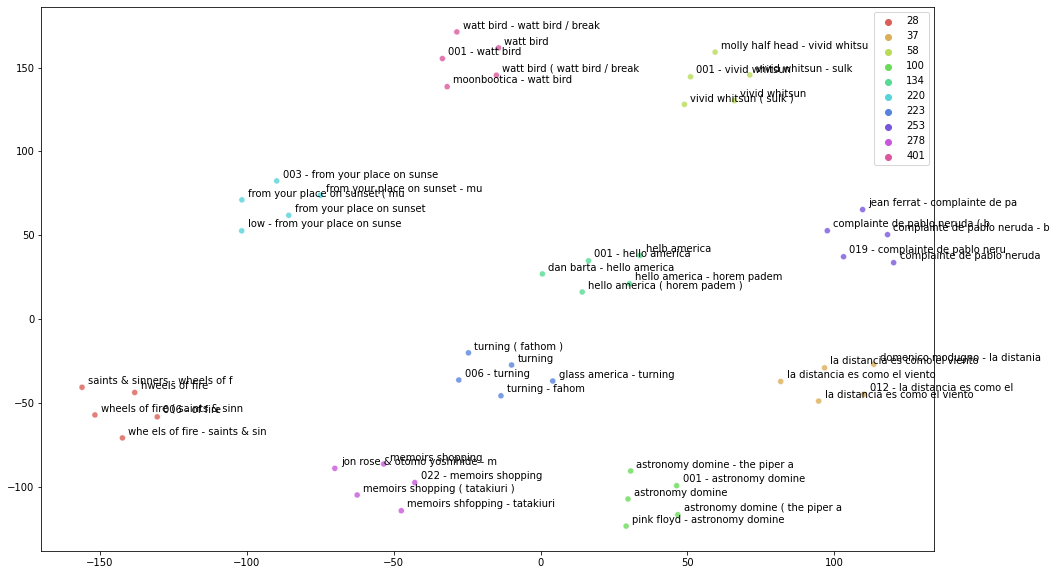

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['title'][:30]
    ax.text(x + 2, y + 2, text)